## Education and Food Security: a Classification Problem
From the [Food Deserts in the USA](https://www.kaggle.com/tcrammond/food-access-and-food-deserts?select=food_access_research_atlas.csv) dataset on Kaggle: "the USDA defines living in a food desert as: living more than one mile from a supermarket in urban/suburban areas, and more than 10 miles from a supermarket in rural areas". 

### Indicators of Food Access
From the documentation, we know the following:
- Accessibility to sources of healthy food, as measured by distance to a store or by the number of stores in an area.
- Individual-level resources that may affect accessibility, such as family income or vehicle availability.
- Neighborhood-level indicators of resources, such as the average income of the neighborhood and the availability of public transportation.

### Our Goal
Using classification, **we will identify if a county is a food desert or not**. We will predict this using demographic information, academic performance, income etc. To test our results, we will use labels that contain flags to indicate if a county is a food desert. We will bin the food dessert boolean averages, use principal componenent analysis (PCA) to feed the data into classification models.

In [508]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # standardizing data
from sklearn.decomposition import PCA # principal componenent analysis
from sklearn import tree #decision tree
pd.set_option('display.max_colwidth', 0) #text reflow in columns
from sklearn.metrics import accuracy_score #generate accuracy score
from sklearn.ensemble import RandomForestClassifier #random forest model
from sklearn.neural_network import MLPClassifier #neural network
from sklearn.linear_model import LogisticRegression #logistic regression
import matplotlib.pyplot as plt
import numpy as np

## Dataset
The combined data set, as generated from the [Data Exploration notebook](https://github.com/archanaramakrishnan/EECS731-Final-Project/blob/main/notebooks/Data%20Exploration.ipynb) is loaded into a dataframe.

In [509]:
combined_df = pd.read_csv("../data/new_combined_data.csv")
combined_df.head()

,Unnamed: 0,Educ_index,Educ_countyid,Educ_fips,Educ_gap_est,Educ_tot_asmts,Educ_cellcount,Educ_mn_asmts,Educ_mn_avg_ol,Educ_mn_grd_ol,...,Food_HUNVFlag,Food_LowIncomeTracts,Food_LA1and10,Food_LAhalfand10,Food_LA1and20,Food_LATracts_half,Food_LATracts1,Food_LATracts10,Food_LATracts20,Food_LATractsVehicle_20
0,0,0,1001,1,0,72864,96,759.000000,5.636815,1.048619,...,0.367558,0.113815,0.712558,0.752323,0.494695,0.534460,0.494695,0.217863,0.0,0.367558
1,1,15,1003,1,0,213214,96,2220.979167,5.428993,0.832481,...,0.131622,0.193888,0.454015,0.477223,0.430768,0.453976,0.430768,0.023246,0.0,0.131622
2,2,30,1005,1,0,26521,96,276.260417,3.692509,0.956793,...,0.478931,0.768438,0.579087,0.579087,0.241760,0.241760,0.241760,0.337327,0.0,0.478931
3,3,44,1007,1,0,25678,96,267.479167,4.235791,0.996612,...,0.382588,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.382588
4,4,56,1009,1,0,71940,96,749.375000,4.689641,0.866955,...,0.387931,0.434510,0.275304,0.275304,0.122989,0.122989,0.122989,0.152315,0.0,0.387931


### Identifying labels

There are lots of columns in our dataset. Let's find the ones that we will use as labels. We will look for any columns that hold values to indicate if the county is a food desert:

In [510]:
food_doc = pd.read_csv("../data/food_access_variable_lookup.csv")

In [511]:
desert_flags_labels = food_doc[food_doc['Description'].str.contains('food desert')]
desert_flags_labels

,Field,LongName,Description
9,LILATracts_1And10,Low income and low access tract measured at 1 mile for urban areas and 10 miles for rural areas,Flag for food desert when considering low accessibilty at 1 and 10 miles
10,LILATracts_halfAnd10,Low income and low access tract measured at 1/2 mile for urban areas and 10 miles for rural areas,Flag for food desert when considering low accessibilty at 1/2 and 10 miles
11,LILATracts_1And20,Low income and low access tract measured at 1 mile for urban areas and 20 miles for rural areas,Flag for food desert when considering low accessibilty at 1 and 20 miles
12,LILATracts_Vehicle,Low income and low access tract using vehicle access or low income and low access tract measured at 20 miles,Flag for food desert when considering vehicle access or at 20 miles


We idetified the following as our labels and store the names in a list for future use:

In [512]:
label_list = desert_flags_labels['Field'].tolist()
label_list = list(map(lambda label: 'Food_' + label, label_list) )
print(label_list)

['Food_LILATracts_1And10', 'Food_LILATracts_halfAnd10', 'Food_LILATracts_1And20', 'Food_LILATracts_Vehicle']


### Average of Boolean Values
From [0-Data_Exploration_And_Cleaning.ipynb](https://github.com/archanaramakrishnan/EECS731-Final-Project/blob/main/notebooks/0-Data_Exploration_And_Cleaning.ipynb) and [Data Exploration notebook](https://github.com/archanaramakrishnan/EECS731-Final-Project/blob/main/notebooks/Data%20Exploration.ipynb): "For boolean type variables, the resulting average will represent a percentage (in decimal form) of how many tracts in that county had a value of 1 before combining." 

These percentages indicate how much of a food desert a Census-Tract is, where a value close to zero is not a less of a food desert than a value close to 1. 

In [513]:
desert_flags = combined_df[label_list]
desert_flags.head()

,Food_LILATracts_1And10,Food_LILATracts_halfAnd10,Food_LILATracts_1And20,Food_LILATracts_Vehicle
0,0.113815,0.113815,0.052977,0.113815
1,0.102367,0.102367,0.102367,0.076038
2,0.347525,0.347525,0.166916,0.322213
3,0.000000,0.000000,0.000000,0.382588
4,0.000000,0.000000,0.000000,0.264942


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b643490>,
      dtype=object)

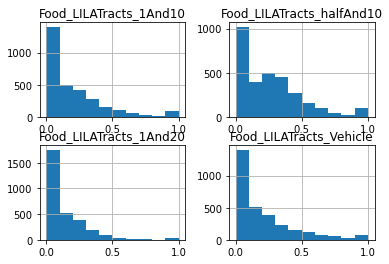

In [514]:
desert_flags.hist()

### Binning the Average Values

To indicate what category of a food desert a Census-Tract is, we create 5 bins:
- 1: 0% - 20% 
- 2: 21% - 40% 
- 3: 41% - 60% 
- 4: 61% - 80%
- 5: 81% - 100%
- 6: invalid input (negatives or greater than 100%)

In [515]:
def bin_desert(percent, bins):
    for i in range(1, bins+1):
        if percent <= i/bins and percent >= 0:
            return i
        
    return bins+1 

In [516]:
desert_flags = desert_flags.apply(lambda x : x.apply( lambda y : bin_desert(y, 5)))
desert_flags.head()

,Food_LILATracts_1And10,Food_LILATracts_halfAnd10,Food_LILATracts_1And20,Food_LILATracts_Vehicle
0,1,1,1,1
1,1,1,1,1
2,2,2,1,2
3,1,1,1,2
4,1,1,1,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1259d9730>,
      dtype=object)

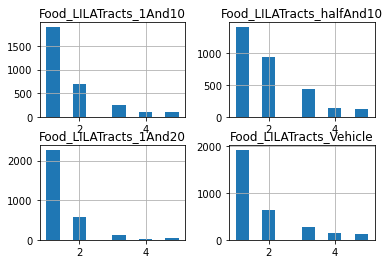

In [517]:
desert_flags.hist()

We put these values back into the dataframe:

In [518]:
combined_df[label_list] = desert_flags

### Dealing with NaN values

In [519]:
combined_df[combined_df.isna().any(axis=1)].head()

,Unnamed: 0,Educ_index,Educ_countyid,Educ_fips,Educ_gap_est,Educ_tot_asmts,Educ_cellcount,Educ_mn_asmts,Educ_mn_avg_ol,Educ_mn_grd_ol,...,Food_HUNVFlag,Food_LowIncomeTracts,Food_LA1and10,Food_LAhalfand10,Food_LA1and20,Food_LATracts_half,Food_LATracts1,Food_LATracts10,Food_LATracts20,Food_LATractsVehicle_20
67,67,1142,2230,2,0,325,67,4.850746,7.531304,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
159,159,2363,6003,6,0,533,61,8.737705,5.046593,NaN,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
217,217,3204,8003,8,0,7778,42,185.190476,5.493467,NaN,...,0.310521,1.000000,0.836063,0.836063,0.721140,0.721140,0.721140,0.114924,0.0,0.310521
218,218,3214,8005,8,0,308032,37,8325.189189,5.996026,0.930396,...,0.145768,0.363584,0.280673,0.905959,0.271745,0.897030,0.271745,0.008928,0.0,0.145768
219,219,3229,8007,8,0,4491,43,104.441860,5.731876,NaN,...,0.000000,0.711437,0.540963,0.540963,0.442651,0.442651,0.442651,0.098312,0.0,0.000000


In [520]:
total_rows = combined_df.shape[0]
nan_rows = combined_df[combined_df.isna().any(axis=1)].shape[0]
(nan_rows/total_rows)*100

3.8272816486751715

3.83 percent of all the rows contain some undefined data. We chose to fill the NaN values with the mean of the column they occur in.

In [521]:
combined_df = combined_df.fillna(combined_df.mean())

## Splitting the Data

From the [Data Exploration](https://github.com/archanaramakrishnan/EECS731-Final-Project/blob/main/notebooks/Data%20Exploration.ipynb) notebook, we have the following columns:
- bool_columns: binary data
- tot_columns: absolute numbers
- pct_columns: percentage data
- other_colns: geographical data, family income, census tract

When deciding which columns to use as features for the classification model, we decided to use percentages instead of absolute numbers. So, we drop the latter. The boolean values are helpful information. Identifier like state names, Federal Information Processing Standards (FIPS) codes are unhelpful in finding correlations, so we remove them.

In [522]:
# absolte value columns that are not required
tot_columns  = ['POP2010',
                'OHU2010',
                'NUMGQTRS',
                'LAPOP1_10',
                'LAPOP05_10',
                'LAPOP1_20',
                'LALOWI1_10',
                'LALOWI05_10',
                'LALOWI1_20',
                'lapophalf',
                'lalowihalf',
                'lakidshalf',
                'laseniorshalf',
                'lawhitehalf',
                'lablackhalf',
                'laasianhalf',
                'lanhopihalf',
                'laaianhalf',
                'laomultirhalf',
                'lahisphalf',
                'lahunvhalf',
                'lasnaphalf',
                'lapop1',
                'lalowi1',
                'lakids1',
                'laseniors1',
                'lawhite1',
                'lablack1',
                'laasian1',
                'lanhopi1',
                'laaian1',
                'laomultir1',
                'lahisp1',
                'lahunv1',
                'lasnap1',
                'lapop10',
                'lalowi10',
                'lakids10',
                'laseniors10',
                'lawhite10',
                'lablack10',
                'laasian10',
                'lanhopi10',
                'laaian10',
                'laomultir10',
                'lahisp10',
                'lahunv10',
                'lasnap10',
                'lapop20',
                'lalowi20',
                'lakids20',
                'laseniors20',
                'lawhite20',
                'lablack20',
                'laasian20',
                'lanhopi20',
                'laaian20',
                'laomultir20',
                'lahisp20',
                'lahunv20',
                'lasnap20',
                'TractLOWI',
                'TractKids',
                'TractSeniors',
                'TractWhite',
                'TractBlack',
                'TractAsian',
                'TractNHOPI',
                'TractAIAN',
                'TractOMultir',
                'TractHispanic',
                'TractHUNV',
                'TractSNAP',]

# other columns that are not required

location_columns = ['County', 'State', 'Educ_fips', 'Educ_countyid']

education_columns = ['Educ_cellcount',  'Educ_tot_asmts', 'Educ_gap_est']

tot_columns = list(map(lambda label: 'Food_' + label, tot_columns) )

We will run a model for each of the classes we identified (names stored in label_list). The features we will use will be the same across all models.

In [523]:
features = combined_df.copy();
features = features.drop(columns = (tot_columns + label_list + location_columns + education_columns))

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(features, combined_df[label_list[0]], test_size=0.1, random_state=0)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(features, combined_df[label_list[1]], test_size=0.1, random_state=0)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(features, combined_df[label_list[2]], test_size=0.1, random_state=0)
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(features, combined_df[label_list[3]], test_size=0.1, random_state=0)

The features contain the following number of columns from each dataset:

In [524]:
col_names = list(features.columns.values.tolist())
edu = 0
food = 0
for col in col_names:
    if 'Educ_' in col:
        edu = edu + 1
    if 'Food_' in col:
        food = food + 1
        
print(str(edu) + " education data columns")
print(str(food) + " food data columns")

18 education data columns
67 food data columns


# Accuracy

Explain accuracy calculation here:

In [525]:
def class_closeness_accuracy(truth, pred):
    if (len(truth) != len(pred)):
        print ("Arguments must be of equal length (RIP your control flow)")
        return None
    corr = 0
    off1 = 0
    off2 = 0
    off3 = 0
    off4 = 0
    
    for t,p in zip(truth, pred):
        diff = abs(t-p)
        
        if (diff == 0):
            corr += 1
        elif (diff == 1):
            off1 += 1
        elif (diff == 2):
            off2 += 1
        elif (diff == 3):
            off3 += 1
        elif (diff == 4):
            off4 += 1
    
    return (corr, off1, off2, off3, off4)
 
def print_class_closeness(truth, pred):
    c, o1, o2, o3, o4 = class_closeness_accuracy(truth, pred)
    
    print ("Correct:", c)
    print ("Off by 1:", o1)
    print ("Off by 2:", o2)
    print ("Off by 3:", o3)
    print ("Off by 4:", o4)

## Principal Component Analysis (PCA)

PCA helps us trim down the number of features for some of our models to perform better. First, we standardize the data. Here, we are tranforming the data to unit scale, where mean = 0 and variance = 1, to have better performance of the model. We apply PCA by making an instance of the model and fitting PCA on the training set.

In [526]:
def pca(X_train, X_test):
    # Fit on training set only.
    scaler = StandardScaler()
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train_pca = scaler.transform(X_train)
    X_test_pca = scaler.transform(X_test)
    
    # Make an instance of the Model and fit
    pca = PCA(.95)
    pca.fit(X_train_pca)

    # Apply transform to both the training set and the test set.
    X_train_pca = pca.transform(X_train_pca)
    X_test_pca = pca.transform(X_test_pca)
    
    return (X_train_pca, X_test_pca)

## Classification Models

In [527]:
def run_model(X_train, X_test, Y_train, Y_test, model):
    model.fit(X_train, Y_train)
    prediction = model.predict(X_test)
    print("\nAccuracy: " + 
      str((accuracy_score(Y_test, prediction)*100).round(5)) + '%')
    print_class_closeness(Y_test, prediction)
    compare_plot(prediction, Y_test)

In [528]:
def draw_plot(prediction, real):
    fig, axs = plt.subplots()
    axs.hist([prediction, real], bins=5, color=['green', 'blue'], label = ['Prediction', 'Real'])
    plt.legend()
    plt.show()

We used the decision tree on the original data as it does not require data normalisation. It gave us one of the best results for supervised learning models.

Decision Tree Classifier

Accuracy: 80.06536%
Correct: 245
Off by 1: 59
Off by 2: 2
Off by 3: 0
Off by 4: 0


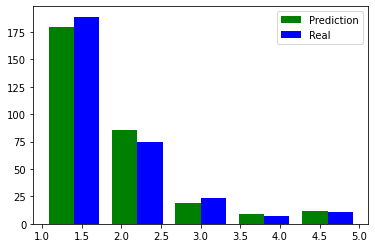

In [529]:
print("Decision Tree Classifier")
run_model(X_train1, X_test1, Y_train1, Y_test1, tree.DecisionTreeClassifier())

Next, we used the logistic regression model which worked better with the normalized data after performing PCA.


Logistic Regression

Accuracy: 73.85621%
Correct: 226
Off by 1: 72
Off by 2: 8
Off by 3: 0
Off by 4: 0


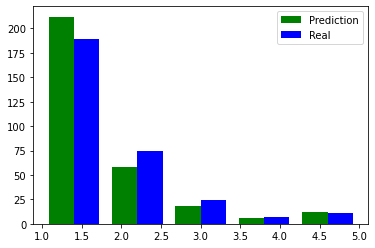

In [530]:
X_train_pca, X_test_pca = pca(X_train1, X_test1) 
print("\nLogistic Regression")
run_model(X_train_pca, X_test_pca, Y_train1, Y_test1, LogisticRegression(random_state=0, max_iter=550))